In [1]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

nvidia-persistenced failed to initialize. Check syslog for more details.
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

from core import *
from torch_backend import *

### Network definitions

In [4]:
def res_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
        'branch': {
            'conv1': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False),
            'bn2': batch_norm(c_out, **kw),
            'relu2': nn.ReLU(True),
            'conv2': nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        }
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), [rel_path('relu1')])
    block['add'] =  (Add(), [(rel_path('conv3') if projection else rel_path('relu1')), rel_path('branch', 'conv2')])
    return block

def DAWN_net(c=64, block=res_block, prep_bn_relu=False, concat_pool=True, **kw):    
    if isinstance(c, int):
        c = [c, 2*c, 4*c, 4*c]
        
    classifier_pool = {
        'in': Identity(),
        'maxpool': nn.MaxPool2d(4),
        'avgpool': (nn.AvgPool2d(4), [rel_path('in')]),
        'concat': (Concat(), [rel_path('avgpool')]),
    } if concat_pool else {'pool': nn.MaxPool2d(4)}
    
    return {
        'prep': union({'conv': nn.Conv2d(3, c[0], kernel_size=3, stride=1, padding=1, bias=False)},
                      {'bn': batch_norm(c[0], **kw), 'relu': nn.ReLU(True)} if prep_bn_relu else {}),
        'layer1': {
            'block0': block(c[0], c[0], 1, **kw),
            'block1': block(c[0], c[0], 1, **kw),
        },
        'layer2': {
            'block0': block(c[0], c[1], 2, **kw),
            'block1': block(c[1], c[1], 1, **kw),
        },
        'layer3': {
            'block0': block(c[1], c[2], 2, **kw),
            'block1': block(c[2], c[2], 1, **kw),
        },
        'layer4': {
            'block0': block(c[2], c[3], 2, **kw),
            'block1': block(c[3], c[3], 1, **kw),
        },
        'final': union(classifier_pool, {
            'flatten': Flatten(),
            'linear': nn.Linear(2*c[3] if concat_pool else c[3], 10, bias=True),
        }),
        'classifier': Identity(),
    }


def conv_bn(c_in, c_out, bn_weight_init=1.0, stride=1, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False), 
        'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'relu': nn.ReLU(True)
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'prep': conv_bn(3, channels['prep'], **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'pool': nn.AvgPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'classifier': Mul(weight),
    }

def net(channels=None, weight=0.125, pool=nn.AvgPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    residual = lambda c, **kw: {'in': Identity(), 'res1': conv_bn(c, c, **kw), 'res2': conv_bn(c, c, **kw), 
                                'add': (Add(), [rel_path('in'), rel_path('res2', 'relu')])}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n


losses = {
    'loss':  (nn.C(reduce=False), [('classifier',), ('target',)]),
    'correct': (Correct(), [('classifier',), ('target',)]),
}

remove_identity_nodes = lambda net: remove_by_type(net, Identity)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


### Download and preprocess data

In [6]:
DATA_DIR = './data'
dataset = cifar10(DATA_DIR)
t = Timer()
print('Preprocessing training data')
train_set = list(zip(transpose(normalise(pad(dataset['train']['data'], 4))), dataset['train']['labels']))
print(f'Finished in {t():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(transpose(normalise(dataset['test']['data'])), dataset['test']['labels']))

train_set = list(zip(transpose(dataset['train']['data'][:1024]), dataset['train']['labels']))
test_set = list(zip(transpose(dataset['test']['data'][:4096]), dataset['test']['labels']))
print(f'Finished in {t():.2} seconds')

Files already downloaded and verified
Files already downloaded and verified
Preprocessing training data
Finished in 2.5 seconds
Preprocessing test data
Finished in 0.1 seconds


(50000, 32, 32, 3)

### Training loop

In [8]:
def train(model, lr_schedule, optimizer, train_set, test_set, batch_size, num_workers=0):
    train_batches = Batches(train_set, batch_size, shuffle=True, set_random_choices=True, num_workers=num_workers)
    test_batches = Batches(test_set, batch_size, shuffle=False, num_workers=num_workers)
    optimizer.opt_params['lr'] = lambda step: lr_schedule(step/len(train_batches))/batch_size
    table, timer = TableLogger(), Timer()
    for epoch in range(lr_schedule.knots[-1]):
        epoch_stats = train_epoch(model, train_batches, test_batches, optimizer.step, timer, test_time_in_total=True) 
        summary = union({'epoch': epoch+1, 'lr': lr_schedule(epoch+1)}, epoch_stats)
        table.append(summary)
    return summary

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - DAWNbench baseline + no initial bn-relu+ efficient dataloading/augmentation, 1 dataloader process (301s)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - double width, 60 epoch train! (321s; test acc 93.5%)

ne approach that doesn't seem particularly promising is to just add width. 

If we double the channel dimensions and train for 60 epochs we can reach 93.5% test accuracy with a 5 layer network. This is nice but not efficient since training now takes 321s.

Finished in 4.6e+01 seconds
{'prep': {'conv': Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 'bn': BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 'relu': ReLU(inplace)}, 'layer1': {'conv': Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 'bn': BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 'relu': ReLU(inplace), 'pool': AvgPool2d(kernel_size=2, stride=2, padding=0)}, 'layer2': {'conv': Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 'bn': BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 'relu': ReLU(inplace), 'pool': AvgPool2d(kernel_size=2, stride=2, padding=0)}, 'layer3': {'conv': Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 'bn': BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 'relu': ReLU(inplace), 'pool': AvgPo

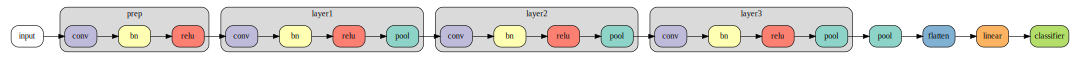

RuntimeError: _thnn_conv2d_forward is not implemented for type torch.HalfTensor

In [10]:

train_set = list(zip(transpose(dataset['train']['data'][:4096]), np.eye(10, dtype="float32")[dataset['train']['labels']]))
test_set = list(zip(transpose(dataset['test']['data'][:4096]), np.eye(10, dtype="float32")[dataset['test']['labels']]))

train_set = list(zip(transpose(dataset['train']['data'][:4096]), dataset['train']['labels']))
test_set = list(zip(transpose(dataset['test']['data'][:4096]), dataset['test']['labels']))

print(f'Finished in {t():.2} seconds')
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 256
c = 128
n = net(channels={'prep': c, 'layer1': 4*c, 'layer2': 8*c, 'layer3': 16*c}, extra_layers=(), res_layers=())
print(n)
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [])

summary=train(model, lr_schedule, opt, train_set_x, test_set, 
              batch_size=batch_size, num_workers=0)

In [22]:
print(summary)

{'epoch': 360, 'lr': 0.0, 'train time': 14.96689772605896, 'train loss': 0.036865281143188475, 'train acc': 0.99894, 'test time': 0.9722542762756348, 'test loss': 0.2720895544052124, 'test acc': 0.9133, 'total time': 5766.217041730881}


### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - extra:L1+L2+L3 network, 60 epochs, cutout=12 (180s, 95.0% test acc) 

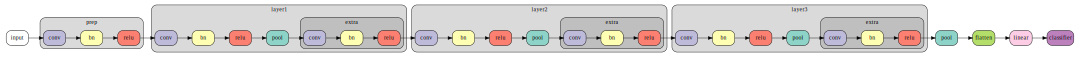

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333       3.4445       1.8571       0.3390       0.2635       1.6723       0.4054       3.7080
           2       0.0667       2.6818       1.1796       0.5765       0.1940       0.9478       0.6556       6.5838
           3       0.1000       2.7352       0.8991       0.6836       0.1946       1.2571       0.6007       9.5136
           4       0.1333       2.6792       0.7638       0.7338       0.1938       0.6789       0.7684      12.3865
           5       0.1667       2.6790       0.6880       0.7593       0.1942       0.6666       0.7731      15.2597
           6       0.2000       2.6813       0.6320       0.7809       0.1942       0.6575       0.7732      18.1352
           7       0.2333       2.7264       0.5933       0.7934       0.1947       0.7307       0.7545      21.0562
           8       0.2667       2.6791       0.5655       0.8046

In [13]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
cutout=12

n = net(extra_layers=['layer1', 'layer2', 'layer3'], res_layers=())
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(cutout, cutout)])
summary = train(model, lr_schedule, opt, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network Residual:L1+L3, 20 epochs (66s; test acc 93.7%)

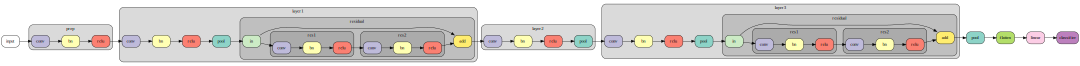

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.9605       1.5841       0.4281       0.2195       1.1686       0.5865       3.1801
           2       0.2000       2.9629       0.9454       0.6631       0.2759       0.8585       0.7054       6.4188
           3       0.3000       2.9642       0.7213       0.7491       0.2190       0.7146       0.7409       9.6020
           4       0.4000       2.9646       0.6209       0.7841       0.2186       0.8419       0.7226      12.7852
           5       0.3750       2.9637       0.5321       0.8178       0.2186       0.5625       0.8072      15.9675
           6       0.3500       2.9598       0.4671       0.8410       0.2688       0.6967       0.7550      19.1960
           7       0.3250       2.9616       0.4235       0.8552       0.2188       0.7235       0.7547      22.3765
           8       0.3000       2.9597       0.3848       0.8694

In [14]:
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, opt, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network, 24 epochs (79s; test acc 94.1%)

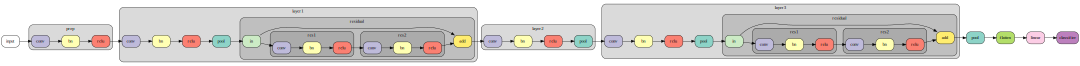

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0800       2.9545       1.6042       0.4199       0.2184       1.1629       0.5758       3.1729
           2       0.1600       2.9604       0.9170       0.6724       0.2195       0.9615       0.6635       6.3529
           3       0.2400       3.0128       0.7207       0.7483       0.2183       0.7565       0.7382       9.5839
           4       0.3200       2.9565       0.6183       0.7838       0.2188       1.1623       0.6477      12.7593
           5       0.4000       2.9525       0.5530       0.8088       0.2182       1.0094       0.6839      15.9300
           6       0.3789       2.9570       0.4969       0.8286       0.2180       0.5447       0.8138      19.1050
           7       0.3579       2.9556       0.4450       0.8492       0.2656       0.7271       0.7555      22.3261
           8       0.3368       2.9508       0.4059       0.8614

In [16]:
lr_schedule = PiecewiseLinear([0, 5, 24], [0, 0.4, 0])
batch_size = 512

n = net()
display(DotGraph(n))
model = Network(union(n, losses)).to(device).half()
opt = SGD(trainable_params(model), momentum=0.9, weight_decay=5e-4*batch_size, nesterov=True)
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, opt, train_set_x, test_set, batch_size=batch_size, num_workers=0)